In [166]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']



# Preparazione dei dati

In [167]:
#attori  con più di 8 ruoli che hanno eseguito nella loro carriera
df= pd.DataFrame( db.people.aggregate([{"$match" : {"jobs.8":{"$exists" : True}}}, {'$project': {'name': 1, 'gender': 1}
    }]))
df.head()

,_id,name,gender
0,15111,Jean-Claude Van Damme,2
1,14639,Mel Brooks,2
2,138,Quentin Tarantino,2
3,776,Eddie Murphy,2
4,1032,Martin Scorsese,2


In [168]:
#attori  con solo 2 ruoli  nella loro carriera
dfless= pd.DataFrame( db.people.aggregate([{ '$match': {'jobs': {'$size': 2}}},{'$project': {'name': 1, 'gender': 1}
    }]))
dfless.head()

,_id,name,gender
0,12899,Jim Varney,2
1,12900,Wallace Shawn,2
2,58563,David Alan Grier,2
3,8851,Whitney Houston,1
4,9780,Angela Bassett,1


In [169]:
#lista dei film
df_film = pd.DataFrame(db.metadata.find({}, {'_id':1, 'vote_average':1 , 'vote_count':1 }))



In [170]:
df_film.shape

(45433, 3)

In [171]:
#rinomino la colonna _id in movie_id
df_film =  df_film.rename(columns = {'_id' : 'movie_id'})

In [172]:
#Lista crew
#prendo dalla collection crew l' id della persona del film e il ruolo svolto
df_crew = pd.DataFrame(db.crew.find({}, {'person_id':1, 'movie_id':1,'_id':0,'department':1})).astype({'movie_id': 'int32','person_id': 'int32'})

df_crew

,department,person_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
464309,Sound,549356,67758
464310,Camera,58818,67758
464311,Directing,1085341,227506
464312,Production,1195656,227506


In [173]:
df_crew.dtypes

department    object
person_id      int32
movie_id       int32
dtype: object

In [174]:
#rinomino l' id delle persone da person_id a _id
df_crew =  df_crew.rename(columns = {'person_id' : '_id'})
df_crew.head()


,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862


In [175]:
#Lista cast
#prendo dalla collection cast l' id della persona del film e come ruolo svolto metto attore, mi servirà quando andrò a fare la concat
df_cast = pd.DataFrame(db.cast.find({}, {'person_id':1, 'movie_id':1,'_id':0})).astype({'movie_id': 'int32','person_id': 'int32'})

df_cast['department'] = "Actor"
df_cast.head()

,person_id,movie_id,department
0,31,862,Actor
1,12898,862,Actor
2,7167,862,Actor
3,12899,862,Actor
4,12900,862,Actor


In [176]:
#rinomino l' id delle persone da person_id a _id
df_cast =  df_cast.rename(columns = {'person_id' : '_id'})

In [177]:
#concateno i due dataframe così ho tutti i ruoli che una persona ha svolto
df_crew = pd.concat([df_crew,df_cast],ignore_index=True)
df_crew

,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
1026783,Actor,544742,227506
1026784,Actor,1090923,227506
1026785,Actor,1136422,227506
1026786,Actor,1261758,227506


In [178]:
#join tra il dataframe contenente le persone che hanno svolto più ruoli e df_crew che contiene i vari ruoli eseguiti e il movie_id
df_firstmerge = pd.merge(df, df_crew, on='_id')
df_firstmerge

,_id,name,gender,department,movie_id
0,15111,Jean-Claude Van Damme,2,Writing,9103
1,15111,Jean-Claude Van Damme,2,Directing,9103
2,15111,Jean-Claude Van Damme,2,Production,10366
3,15111,Jean-Claude Van Damme,2,Writing,9594
4,15111,Jean-Claude Van Damme,2,Production,9594
...,...,...,...,...,...
8375,87550,Vishal Bhardwaj,2,Sound,64109
8376,87550,Vishal Bhardwaj,2,Directing,392271
8377,87550,Vishal Bhardwaj,2,Writing,392271
8378,87550,Vishal Bhardwaj,2,Sound,392271


In [179]:
df_firstmerge.shape[0]

8380

In [180]:
#data_it=df_firstmerge[df_firstmerge['department'] == 'Actor']
#data_it
#chi ha da 8 in su ruoli non ha mai fatto l' attore

In [181]:
#persone che hanno fatto solo 2 ruoli
df_lessmerge = pd.merge(dfless, df_crew, on='_id')
df_lessmerge

,_id,name,gender,department,movie_id
0,12899,Jim Varney,2,Crew,10865
1,12899,Jim Varney,2,Actor,862
2,12899,Jim Varney,2,Actor,11041
3,12899,Jim Varney,2,Actor,32302
4,12899,Jim Varney,2,Actor,863
...,...,...,...,...,...
158251,1599742,Hillary Wallace,0,Costume & Make-Up,390959
158252,1471628,Sam Resnick,0,Writing,30840
158253,1471628,Sam Resnick,0,Writing,30840
158254,1182809,Hamid Nematollah,0,Directing,439050


In [182]:
#capire quale raw mi dava problemi perché non rieco a fare join con la collezione metadata
#for i in range(df2.shape[0]):
  #  try:
     #   df2.movie_id[i] = int(df2.movie_id[i])
    
   # except ValueError:
     #  print("String is not Numaric: ", i )

In [183]:
#converto i vari id del dataframe da oggetti a int
df_film.movie_id = df_film.movie_id.astype(str).astype(int)

In [184]:
df_film.dtypes

movie_id          int32
vote_average    float64
vote_count      float64
dtype: object

In [185]:
#faccio il join tra il dataframe contenente le varie persone che hanno svolto da 8 ruoli in su, con i film da loro svolti
df_secondmerge = pd.merge(df_firstmerge, df_film, on='movie_id')


In [186]:
df_secondmerge

,_id,name,gender,department,movie_id,vote_average,vote_count
0,15111,Jean-Claude Van Damme,2,Writing,9103,5.3,126.0
1,15111,Jean-Claude Van Damme,2,Directing,9103,5.3,126.0
2,15111,Jean-Claude Van Damme,2,Actor,9103,5.3,126.0
3,15111,Jean-Claude Van Damme,2,Production,10366,4.2,138.0
4,15111,Jean-Claude Van Damme,2,Actor,10366,4.2,138.0
...,...,...,...,...,...,...,...
8375,87550,Vishal Bhardwaj,2,Writing,139521,5.6,21.0
8376,87550,Vishal Bhardwaj,2,Directing,392271,7.0,10.0
8377,87550,Vishal Bhardwaj,2,Writing,392271,7.0,10.0
8378,87550,Vishal Bhardwaj,2,Sound,392271,7.0,10.0


In [187]:
#prendo solo chi ha effettuato almeno 5 film
prova = df_secondmerge.groupby(['_id', 'movie_id']).count()
prova.reset_index(inplace=True)
prova = prova.groupby('_id').count()
prova =  prova.rename(columns = {'name' : 'count'})
prova.reset_index(inplace=True)
prova = prova.drop(['movie_id','vote_average','gender','vote_count','department'], axis=1)
prova =  prova.loc[prova['count'] >= 5]
prova

,_id,count
0,1,50
1,7,22
2,8,8
3,40,69
4,42,28
...,...,...
163,211962,12
164,220691,6
165,1012097,5
166,1395269,26


In [188]:
df_secondmerge = pd.merge(df_secondmerge, prova, on='_id')
d_secstat = df_secondmerge

In [189]:
df_secondmerge = df_secondmerge.drop_duplicates(subset=['_id', 'movie_id', 'vote_average'])


In [190]:
#prendo la dimensione delle righe di questo dataframe
dfshape1  = df_secondmerge.shape[0]

In [191]:
#applico lo stesso procedimento per le persone che hanno svolto solo due ruoli
df_less_secondmerge = pd.merge(df_lessmerge, df_film, on='movie_id')
d_lesstat = df_less_secondmerge

In [192]:
#prendo solo chi ha effettuato almeno 5 film
prova = df_less_secondmerge.groupby(['_id', 'movie_id']).count()
prova.reset_index(inplace=True)
prova = prova.groupby('_id').count()
prova =  prova.rename(columns = {'name' : 'count'})
prova.reset_index(inplace=True)
prova = prova.drop(['movie_id','vote_average','gender','vote_count','department'], axis=1)
prova =  prova.loc[prova['count'] >= 5]
prova

,_id,count
0,2,47
1,3,57
3,14,11
4,22,18
5,32,37
...,...,...
33991,1813644,33
34109,1835498,7
34292,1902347,5
34299,1904075,5


In [193]:
df_less_secondmerge = pd.merge(df_less_secondmerge,prova, on='_id')

In [194]:
df_less_secondmerge = df_less_secondmerge.drop_duplicates(subset=['_id', 'movie_id', 'vote_average'])
dfshape2 = df_less_secondmerge.shape[0]

In [195]:
df_8 = df_secondmerge.loc[df_secondmerge['vote_average'] >= 7.5]
df_2 = df_less_secondmerge.loc[df_less_secondmerge['vote_average'] >= 7.5]

In [196]:
#la proporzione dei film con votazione maggiore di 7.5 tra tutti i film eseguiti da persone con 8 e più ruoli, 
#chi ha fatto più ruoli è più probabile che partecipi ad un film bello
t1 = (df_8.shape[0]/dfshape1)*100
t1

14.867404468573813

In [197]:
#la proporzione dei film con votazione maggiore di 7.5 tra tutti i film eseguiti da persone con 2 ruoli
t2 = (df_2.shape[0]/dfshape2)*100
t2

8.042320803548016

In [198]:
#analizzo la carriere per queste due tipologie di persone

In [199]:
df_role2 = df_less_secondmerge.groupby("_id").agg({'vote_average':'mean'})
df_role2.reset_index(inplace=True)
df_role2

,_id,vote_average
0,2,6.170213
1,3,6.349123
2,14,5.881818
3,22,4.894444
4,32,6.175676
...,...,...
7775,1813644,5.881818
7776,1835498,6.657143
7777,1902347,6.880000
7778,1904075,6.240000


In [200]:
df_role2.shape

(7780, 2)

In [201]:
df_role8 = df_secondmerge.groupby("_id").agg({'vote_average':'mean'})
df_role8.reset_index(inplace=True)
df_role8

,_id,vote_average
0,1,6.562000
1,7,7.459091
2,8,7.437500
3,40,6.285507
4,42,6.460714
...,...,...
158,211962,5.808333
159,220691,5.616667
160,1012097,2.700000
161,1395269,5.992308


In [202]:
df_role8.shape

(163, 2)

In [203]:
target2 = df_role2.shape[0]
target1 = df_role8.shape[0]

In [217]:
#ORA ANALIZZO LE CARRIERE DELLE DUE TIPOLOGIE DI PERSONE DA UN LATO QUELLI CON 2 RUOLI DALL' ALTRO QUELLI CON MINIMO 8
df_role8 = df_role8.loc[df_role8['vote_average'] >= 7.6]
df_role2 = df_role2.loc[df_role2['vote_average'] >= 7.6]

In [218]:
#la percentuale di avere una media dei voti dell' intera carriera superiore al 7.5 in persone che hanno avuto più di 8 ruoli
proporzione1 = (df_role8.shape[0]/target1)*100
proporzione1

0.0

In [219]:
#la percentuale di avere una media dei voti dell' intera carriera superiore al 7.5 in persone che hanno avuto 2 ruoli
proporzione2 = (df_role2.shape[0]/target2)*100
proporzione2

0.33419023136246784

In [220]:
df_role2.describe()

,_id,vote_average
count,2.600000e+01,26.000000
mean,4.674093e+05,7.763494
std,6.077716e+05,0.186298
min,7.100000e+01,7.600000
25%,8.105500e+03,7.622143
50%,8.038450e+04,7.697500
75%,9.899748e+05,7.821429
max,1.551974e+06,8.285714


In [221]:
df_role8.describe()

,_id,vote_average
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [222]:
df_role8.shape[0]

0

# Grafici

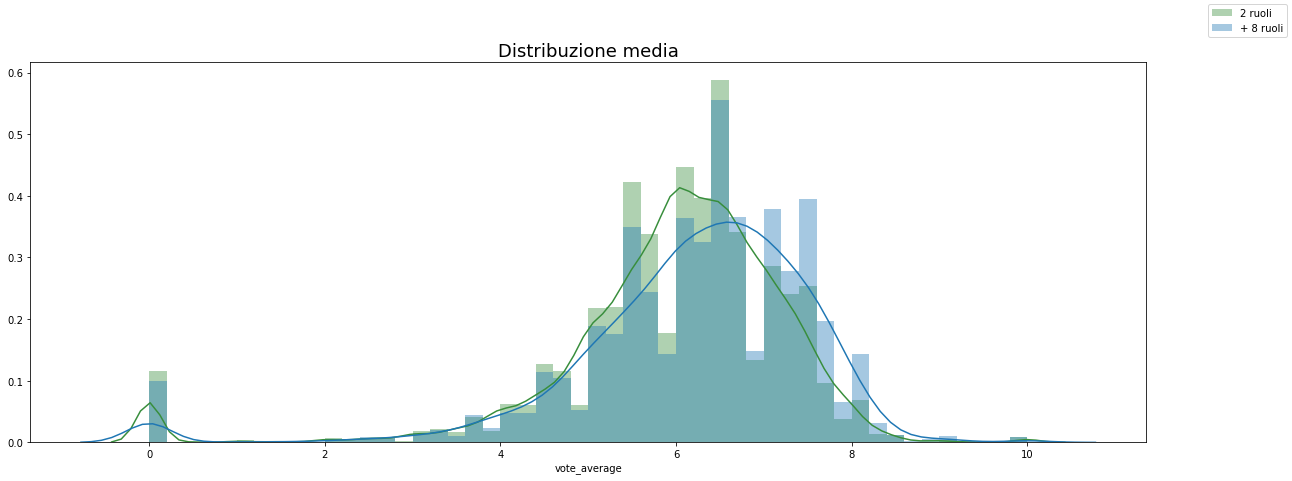

In [223]:
#analizzo la distribuzione di voti nei due casi analizzati
#devo cambiare grafico qua
fig = plt.figure(figsize=(20,7))
sns.distplot(df_less_secondmerge['vote_average'], color='#388E3C')
sns.distplot(df_secondmerge['vote_average'])
plt.title('Distribuzione media', fontsize=18)
fig.legend(labels=['2 ruoli','+ 8 ruoli'])

In [224]:
#QUELLI CHE HANNO FATTO PIù RUOLI IN GENERE TENDONO AD AVER PARTECIPATO A FILM CON VOTI PIù ALTI

C:\Users\monob\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\monob\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\monob\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


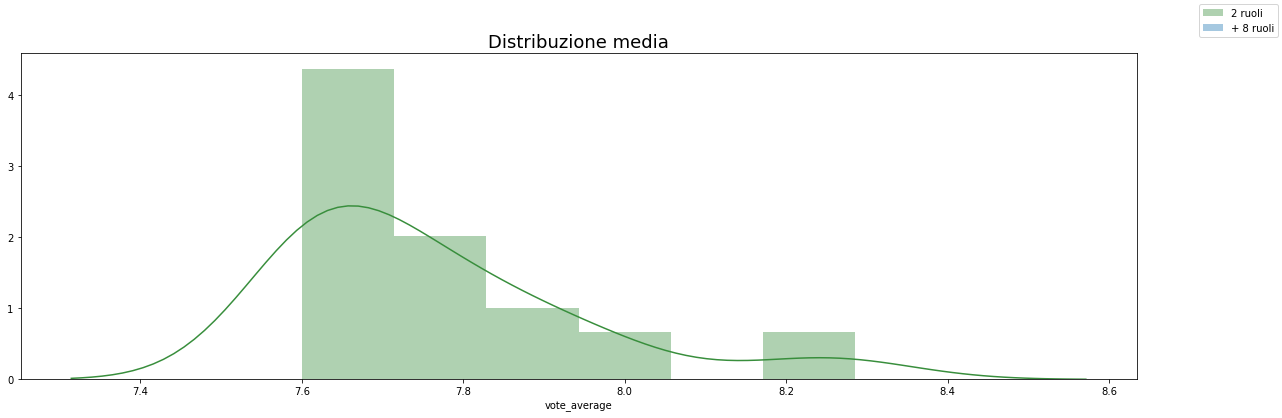

In [225]:
#analizzo la distribuzione di voti nei due casi analizzati
fig = plt.figure(figsize=(20,6))
sns.distplot(df_role2['vote_average'], color='#388E3C')
sns.distplot(df_role8['vote_average'])
plt.title('Votazione carriera', fontsize=18)
fig.legend(labels=['2 ruoli','+ 8 ruoli'])

In [226]:
#possiamo notare che effettivamente chi ha svolto più ruoli a partecipato a film con votazione più alta

In [230]:
d_secstat = d_secstat.loc[d_secstat['vote_average'] >= 7.6]
#df_secondmerge.head()

In [231]:
df_statistics  = d_secstat.groupby("department").count()
df_statistics.reset_index(inplace=True)
df_statistics =  df_statistics.rename(columns = {'name' : 'count'})
df_statistics = df_statistics.drop(['_id','movie_id','vote_average','gender','vote_count'], axis=1)
df_statistics

,department,count
0,Actor,100
1,Art,7
2,Camera,4
3,Crew,17
4,Directing,91
5,Editing,18
6,Production,71
7,Sound,8
8,Visual Effects,3
9,Writing,92


<AxesSubplot:xlabel='department', ylabel='count'>

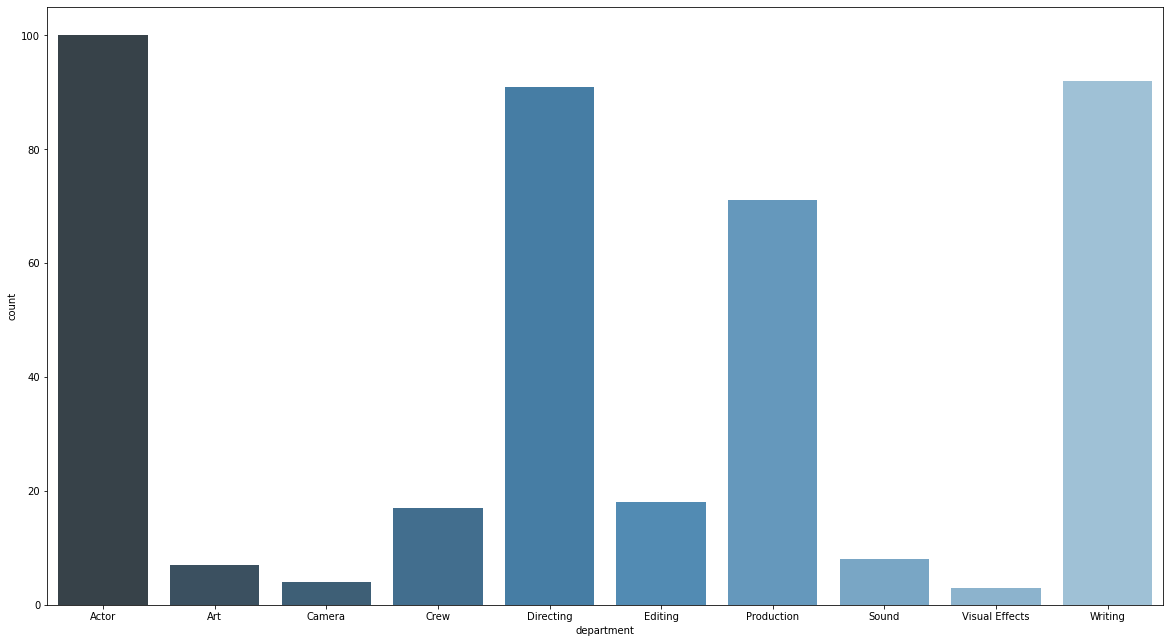

In [232]:
fig = plt.figure(figsize=(20,11))
sns.barplot(y="count", x="department",data = df_statistics, palette="Blues_d")
